In [16]:
import math
import random
import numpy as np
from itertools import product

from qiskit import *

# Importing standard Qiskit libraries
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit.providers.aer import QasmSimulator

from qiskit.utils import QuantumInstance

from qiskit.opflow import I, X, Y, Z
from qiskit.opflow import StateFn
from qiskit.opflow import Gradient
from qiskit.opflow import CircuitSampler
from qiskit.opflow.primitive_ops import MatrixOp
from qiskit.extensions.unitary import UnitaryGate
from qiskit.circuit.library.standard_gates import CZGate
from qiskit.circuit.library.standard_gates import CHGate
from qiskit.circuit.library.standard_gates import CRYGate
from qiskit.circuit.library.standard_gates import HGate
from qiskit.circuit.library.standard_gates import XGate
from qiskit.circuit.library.standard_gates import RXGate
from qiskit.circuit.library.standard_gates import RYGate
from qiskit.circuit.library.standard_gates import RZGate

from qiskit.quantum_info import Statevector

from qiskit.providers.aer.noise import NoiseModel
from qiskit.ignis.mitigation.measurement import CompleteMeasFitter

# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

ibmqfactory.load_account:WARNING:2022-10-26 02:00:35,205: Credentials are already in use. The existing account in the session will be replaced.


In [17]:
def createEqSuperposCollectiveU():
    '''
    Defines a quantum circuit to create the uniform superposition of basis elements required.
    '''
    temp = QuantumCircuit(5)
    
    temp.ry(2*np.arctan(1/np.sqrt(2)), 1)
    temp.x(1)
    temp.append(CHGate(), [1, 0])
    temp.x(1)
    
    temp.ry(np.pi/3, 2)
    temp.x(2)
    temp.append(CRYGate(2*np.arctan(1/np.sqrt(2))), [2, 3])
    temp.x(3)
    temp.append(HGate().control(2), [2, 3, 4])
    temp.x(2)
    temp.x(3)
    
    return temp

In [18]:
def Bx():
    '''
    Defining bilateral rotation Bx.
    '''
    temp = QuantumCircuit(2)
    temp.append(RXGate(-np.pi/2), [0])
    temp.append(RXGate(-np.pi/2), [1])
    return temp

In [19]:
def By():
    '''
    Defining bilateral rotation By.
    '''
    temp = QuantumCircuit(2)
    temp.append(RYGate(-np.pi/2), [0])
    temp.append(RYGate(-np.pi/2), [1])
    return temp

In [20]:
def Bz():
    '''
    Defining bilateral rotation Bz.
    '''
    temp = QuantumCircuit(2)
    temp.append(RZGate(-np.pi/2), [0])
    temp.append(RZGate(-np.pi/2), [1])
    return temp

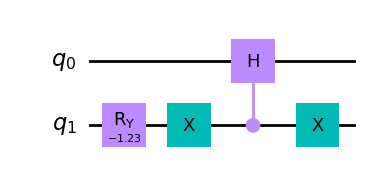

In [21]:
'''
Defines a quantum circuit to create pure state to be tested. State created on qubits (S) on 2 qubits
'''
size = 2
state = QuantumCircuit(size)
state.ry(2*np.arctan(-1/np.sqrt(2)), 1)
state.x(1)
state.append(CHGate(), [1, 0])
state.x(1)
state.draw('mpl')

In [22]:
def createQuantumCircuit():
    '''
    Creates quantum circuit for the problem. 
    Refer to Section 4.C from https://arxiv.org/pdf/2105.12758
    The ciruit contains 7 qubits each labelled as (C, S, S')
    ''' 
    circ = QuantumCircuit(7)
    
    superPosCircuit = createEqSuperposCollectiveU()
    circ.append(superPosCircuit, range(5))
    circ.append(state, [5, 6])
    
    circ.append(Bx().control(1), [4, 5, 6])
    circ.append(Bx().control(1), [4, 5, 6])
    
    circ.append(By().control(1), [3, 5, 6])
    circ.append(By().control(1), [3, 5, 6])

    circ.append(Bz().control(1), [2, 5, 6])
    circ.append(Bz().control(1), [2, 5, 6])
    
    circ.append(By().control(1), [1, 5, 6])
    circ.append(Bx().control(1), [1, 5, 6])
    
    circ.append(Bx().control(1), [0, 5, 6])
    circ.append(By().control(1), [0, 5, 6])

    circ.append(superPosCircuit.inverse(), range(5))
    
    return circ

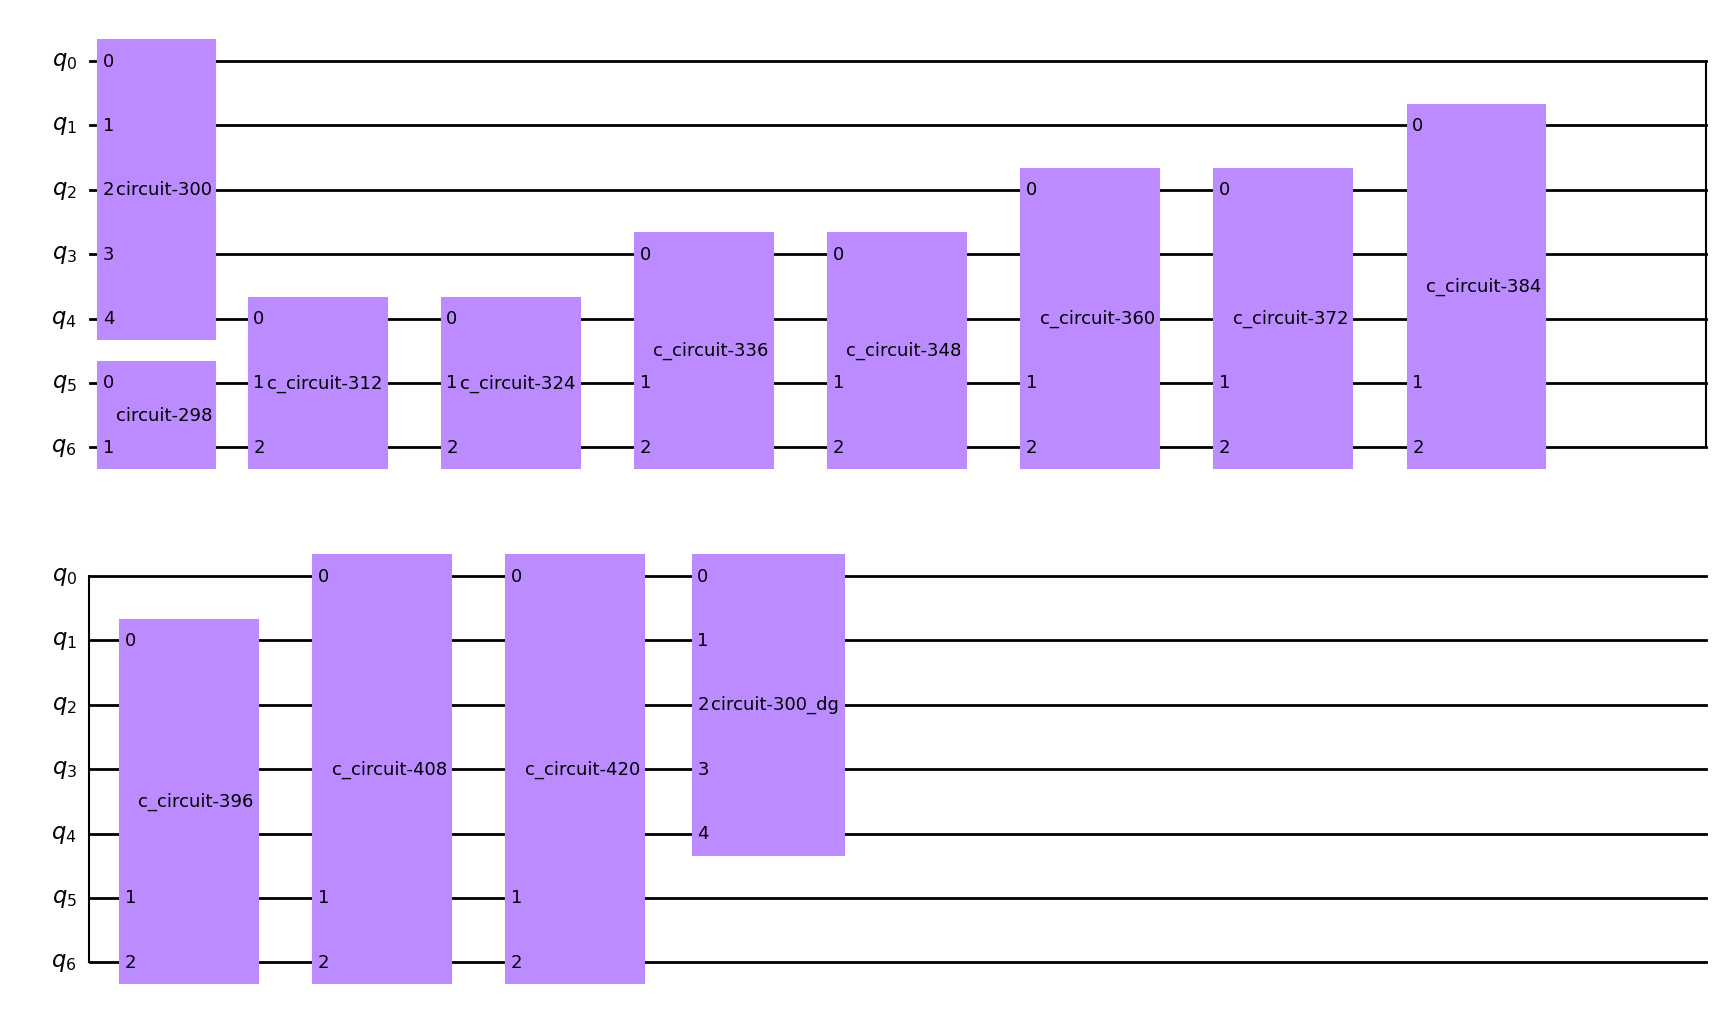

In [23]:
'''
Creates the quantum circuit
'''
qCirc = createQuantumCircuit()
qCirc.draw('mpl')

In [24]:
'''
Pick a backend to use. We use the statevector_simulator for noiseless simulation.
'''
noiseless_backend = Aer.get_backend('statevector_simulator')
noiseless_q_instance = QuantumInstance(noiseless_backend)
noiseless_sampler = CircuitSampler(noiseless_q_instance)

In [26]:
'''
Pick a backend to use. We use the qasm_simulator for noisy simulation. 
'''
#Replace the provider with your personal credentials for hub, group and main
provider = IBMQ.get_provider(hub="ibm-q-research", group="louisiana-st-uni-1", project="main")
noisy_backend = Aer.get_backend("qasm_simulator")
device = provider.get_backend("ibmq_jakarta")
coupling_map = device.configuration().coupling_map
noise_model = NoiseModel.from_backend(device.properties())
noisy_q_instance = QuantumInstance(backend=noisy_backend, 
                           shots=20000, 
                           noise_model=noise_model, 
                           coupling_map=coupling_map,
                           measurement_error_mitigation_cls=CompleteMeasFitter,
                           cals_matrix_refresh_period=30)
noisy_sampler = CircuitSampler(noisy_q_instance)

In [27]:
'''
Average value of this hamiltonian is the probability of measuring 0 on the first five qubits.
MatrixOp(np.array([[1, 0], [0, 0])) is the projector on the 0 subspace. Qiskit orders qubits in reverse.
'''
hamiltonian = I^I^MatrixOp(np.array([[1, 0], [0, 0]]))^MatrixOp(np.array([[1, 0], [0, 0]]))^MatrixOp(np.array([[1, 0], [0, 0]]))^MatrixOp(np.array([[1, 0], [0, 0]]))^MatrixOp(np.array([[1, 0], [0, 0]]))

In [28]:
def costf(noisy = False):
    '''
    Calculates the expectation value.
    '''  
    expectation = StateFn(hamiltonian, is_measurement=True).compose(StateFn(qCirc))
    
    if noisy:
        result = noisy_sampler.convert(expectation).eval()  
    else:
        result = noiseless_sampler.convert(expectation).eval()  
    
    return np.real(result)

In [29]:
print("Cost : ", costf())

Cost :  0.6666666666666662
